In [2]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib

%matplotlib inline

def load_p(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
X_train = load_p("/scratch/pbanerj6/sml-dataset/X_train_tokens.p")
X_val = load_p("/scratch/pbanerj6/sml-dataset/X_val_tokens.p")
X_test = load_p("/scratch/pbanerj6/sml-dataset/X_test_tokens.p")

In [4]:
y_train = load_p("/scratch/pbanerj6/sml-dataset/y_train.p")
y_val = load_p("/scratch/pbanerj6/sml-dataset/y_val.p")
y_test = load_p("/scratch/pbanerj6/sml-dataset/y_test.p")

In [5]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os

In [6]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline

def my_preprocessor(doc):
    return doc
def my_tokenizer(doc):
    return doc

feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f = feature_pipeline.transform(X_val)
X_test_f = feature_pipeline.transform(X_test)


train_dataset = MyDataset(X_train_f.toarray(),y_train)
val_dataset = MyDataset(X_val_f.toarray(),y_val)
test_dataset = MyDataset(X_test_f.toarray(),y_test)

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [9]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

def get_model_1():
    N, D_in, H, D_out = 32, 4946, 200, 2
    return torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),)

def get_model_2():
    N , D_in, H1, H2, D_out = 32, 4946, 200, 100, 2
    return torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),)

# model = get_model_1()
# model = get_model_2()

In [10]:
# model.half()

In [11]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [26]:
def train_model(model,limit_train_examples = 100):
    patience = 20
    max_val_acc = 0.0
    model.to('cuda')
    model = torch.nn.DataParallel(model) 
    learning_rate = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Number of samples",limit_train_examples)
    loss_fn = nn.CrossEntropyLoss()
#     for t in tqdm(range(100),desc="Epoch"):
    for t in range(100):
        print("Epoch:",t)
        model.train()
        total_loss = 0.0
        tmp_acc = 0.0
        steps = 0
        nb_eval_examples = 0
        for x, y in train_loader:
            if nb_eval_examples > limit_train_examples:
                continue
            steps+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits = model(x)
            loss = loss_fn(logits, y)
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            tmp_acc += accuracy(logits, label_ids)
            # Compute and print loss.

            total_loss += loss.mean()
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            nb_eval_examples += x.size(0)

        model.eval()
        val_acc = 0.0
        steps = 0
        nb_val_examples = 0
        for batch_idx, (x, y) in enumerate(val_loader):
            steps+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits = model(x)
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            val_acc += accuracy(logits, label_ids)
            nb_val_examples += x.size(0)

        if max_val_acc < val_acc/nb_val_examples:
            patience = 20
            print("Saving Best Model!!")
            max_val_acc = val_acc/nb_val_examples
            model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
            output_model_file = os.path.join("/scratch/pbanerj6/sml-nn-tokens-v1", "best_model.bin")
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            patience-=1

        if patience == 0:
            print("Validation Accuracy Did Not Improve After", patience, "Epochs. Stopping.")
            break
        print("Epoch:",t,"Loss:",total_loss.item()/steps,"Train Accuracy:",(tmp_acc/nb_eval_examples),"Val Accuracy:",(val_acc/nb_val_examples))
    return max_val_acc


In [37]:
from scipy.stats import rankdata
from scipy.special import softmax

from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def mrrVisualization(n_trainSamples,mrrScore):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("NN_Tokens_Linear_Mrr.png")
    plt.show()
    

def precisionVisualization(n_trainSamples,precisionAt1,precisionAt3):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("NN_Tokens_Linear_Precision.png")
    plt.show()

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

def accuracyVisualization(n_trainSamples,valAccuracy,testAccuracy):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("NN_Tokens_Linear_Accuracy.png")
    #plt.show()

qid2c,qid2indexmap = load_ranking("test")


def test_model(model):
    output_model_file = os.path.join("/scratch/pbanerj6/sml-nn-tokens-v1", "best_model.bin")
    model.load_state_dict(torch.load(output_model_file))
    model.eval()

    model.to('cuda')
    model = torch.nn.DataParallel(model) 
    model.eval()
    val_acc = 0.0
    steps = 0
    nb_val_examples = 0

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=1,
        pin_memory=True
    )

    all_preds = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x=x.to('cuda')
        y=y.to('cuda')
        logits = model(x)
        logits = logits.detach().cpu().numpy()

        for pred in logits:
            all_preds.append(softmax(pred))

        label_ids = y.to('cpu').numpy()
        val_acc += accuracy(logits, label_ids)
        nb_val_examples += x.size(0)

    mrr = mrrwrapper(qid2c,qid2indexmap,all_preds)
    print("Test Accuracy:",(val_acc/nb_val_examples),"MRR:",(mrr))
    return val_acc/nb_val_examples,mrr[0],mrr[1],mrr[2]

In [28]:
#100 : Test Accuracy: 0.5926666666666667 MRR: (0.5170111111111132, 0.27466666666666667, 0.6733333333333333)
#200 : Test Accuracy: 0.5921333333333333 MRR: (0.5180888888888906, 0.27666666666666667, 0.6706666666666666)
# 200-100 : Test Accuracy: 0.5925333333333334 MRR: (0.5254666666666686, 0.2866666666666667, 0.6786666666666666)
# 200-100 : Test Accuracy: 0.5940666666666666 MRR: (0.5177444444444464, 0.276, 0.676)

In [29]:
# Run Orchestrator:
train_samples = [100,1000,10000,20000,50000]
val_accuracies = []
test_accuracies = []
mrr_vals = []
p1s = []
p3s = []

for train_sample in train_samples:
    model = get_model_1()
    # model = get_model_2()
    val_accuracies.append(train_model(model,train_sample))
    del model
    model = get_model_1()
    # model = get_model_2()
    test_acc,mrr,p1,p3=test_model(model)
    test_accuracies.append(test_acc)
    mrr_vals.append(mrr)
    p1s.append(p1)
    p3s.append(p3)
    del model

Number of samples 100
Epoch: 0
Saving Best Model!!
Epoch: 0 Loss: 0.005900751553110477 Train Accuracy: 0.5390625 Val Accuracy: 0.5
Epoch: 1
Epoch: 1 Loss: 0.005924191810428969 Train Accuracy: 0.453125 Val Accuracy: 0.5
Epoch: 2
Epoch: 2 Loss: 0.005923104947055581 Train Accuracy: 0.4609375 Val Accuracy: 0.5
Epoch: 3
Epoch: 3 Loss: 0.005902132754132692 Train Accuracy: 0.546875 Val Accuracy: 0.5
Epoch: 4
Epoch: 4 Loss: 0.005914304810546354 Train Accuracy: 0.4921875 Val Accuracy: 0.5
Epoch: 5
Epoch: 5 Loss: 0.005891322072889251 Train Accuracy: 0.578125 Val Accuracy: 0.5
Epoch: 6
Epoch: 6 Loss: 0.005913955062182981 Train Accuracy: 0.484375 Val Accuracy: 0.5
Epoch: 7
Epoch: 7 Loss: 0.005925310700178655 Train Accuracy: 0.453125 Val Accuracy: 0.5
Epoch: 8
Epoch: 8 Loss: 0.005885158774695163 Train Accuracy: 0.6015625 Val Accuracy: 0.5
Epoch: 9
Epoch: 9 Loss: 0.0059080510251303476 Train Accuracy: 0.5078125 Val Accuracy: 0.5
Epoch: 10
Epoch: 10 Loss: 0.00591202432921192 Train Accuracy: 0.5 Val Ac

In [30]:
test_accuracies

[0.5, 0.5765333333333333, 0.5942, 0.5934, 0.5922666666666667]

In [31]:
model = get_model_1()
# model = get_model_2()
val_accuracies.append(train_model(model,80000))
del model
model = get_model_1()
# model = get_model_2()
test_acc,mrr,p1,p3=test_model(model)
test_accuracies.append(test_acc)
mrr_vals.append(mrr)
p1s.append(p1)
p3s.append(p3)
del model

Number of samples 80000
Epoch: 0
Saving Best Model!!
Epoch: 0 Loss: 3.4516677043077024 Train Accuracy: 0.5838933333333334 Val Accuracy: 0.5849333333333333
Epoch: 1
Saving Best Model!!
Epoch: 1 Loss: 3.390290282682569 Train Accuracy: 0.65716 Val Accuracy: 0.5896666666666667
Epoch: 2
Saving Best Model!!
Epoch: 2 Loss: 3.293716528268257 Train Accuracy: 0.6632133333333333 Val Accuracy: 0.5935333333333334
Epoch: 3
Saving Best Model!!
Epoch: 3 Loss: 3.202117724713486 Train Accuracy: 0.6694666666666667 Val Accuracy: 0.5942
Epoch: 4
Saving Best Model!!
Epoch: 4 Loss: 3.126037467517324 Train Accuracy: 0.6748933333333333 Val Accuracy: 0.5966666666666667
Epoch: 5
Epoch: 5 Loss: 3.065101216851013 Train Accuracy: 0.6798666666666666 Val Accuracy: 0.5963333333333334
Epoch: 6
Saving Best Model!!
Epoch: 6 Loss: 3.0155299985840887 Train Accuracy: 0.6861466666666667 Val Accuracy: 0.5997333333333333
Epoch: 7
Saving Best Model!!
Epoch: 7 Loss: 2.974204122384728 Train Accuracy: 0.69148 Val Accuracy: 0.60193

In [32]:
train_samples.append(75000)

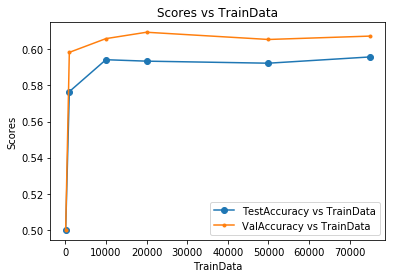

In [38]:
accuracyVisualization(train_samples,val_accuracies,test_accuracies)

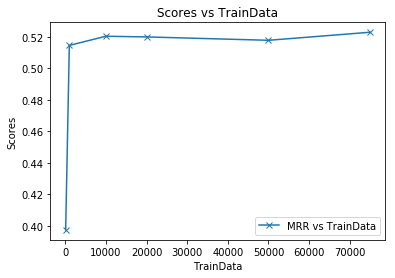

In [39]:
mrrVisualization(train_samples,mrr_vals)

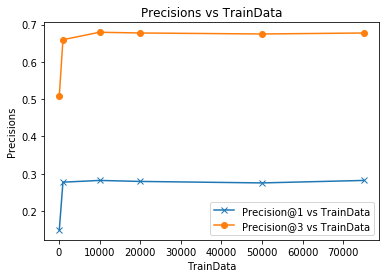

In [40]:
precisionVisualization(train_samples,p1s,p3s)

In [36]:
val_accuracies,test_accuracies,mrr_vals,p1s,p3s


([0.5,
  0.5982666666666666,
  0.6058666666666667,
  0.6094,
  0.6054,
  0.6072666666666666],
 [0.5,
  0.5765333333333333,
  0.5942,
  0.5934,
  0.5922666666666667,
  0.5957333333333333],
 [0.3973571428571427,
  0.5144793650793668,
  0.5203000000000019,
  0.5198666666666688,
  0.5177222222222241,
  0.5228333333333353],
 [0.14933333333333335,
  0.2773333333333333,
  0.282,
  0.2793333333333333,
  0.2753333333333333,
  0.282],
 [0.5086666666666667,
  0.6593333333333333,
  0.6793333333333333,
  0.6773333333333333,
  0.6746666666666666,
  0.6773333333333333])